In [1]:
from fastai.tabular import *
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

# Data preparation

## Get the data

In [2]:
class CryptoDataset:
    """Face Landmarks dataset."""
    TARGET_COLUMN_NAME = 'close'
    DATE_COLUMN_NAME = 'date'
    ELAPSED = 'Elapsed'
    DROP_COLUMNS =['Second', 'Month', 'Year', \
                   'Is_quarter_end', 'Is_quarter_start', \
                   'Is_year_end', 'Is_year_start',
                   'Is_month_end', 'Is_month_start',
                   'Week', 'Dayofyear', ELAPSED]
    True_target_column_name = TARGET_COLUMN_NAME+'_future'

    def __init__(self, csv_file="BTC-ETH-filtered_with_indicators.csv", predict_delta=4, sequence_size=10):
        """
        Args:
            csv_file (string): Path to the csv file with the crypto stats table.
        """
        from datetime import datetime
        self.sequence_size = sequence_size
        self.df = pd.read_csv("BTC-ETH-filtered_with_indicators.csv",
                              #read dates as dates
                              parse_dates=[self.DATE_COLUMN_NAME],
                              date_parser=lambda x: datetime.fromtimestamp(int(x)))
        add_datepart(self.df, self.DATE_COLUMN_NAME, time=True);
        self.df = self.df.astype(float).drop(columns=self.DROP_COLUMNS)
        self.df[self.True_target_column_name] = self.df[self.TARGET_COLUMN_NAME].shift(-predict_delta)
        trvate_split = tuple(int(x * len(self.df)) for x in (0.75, 0.9, 1.0))
        tmp_train_limit = trvate_split[0]- trvate_split[0]%sequence_size
        self.train_df = self.df[:tmp_train_limit]
        tmp_valid_limit = trvate_split[1] - trvate_split[0]%sequence_size -(trvate_split[1]-trvate_split[0])%sequence_size
        self.valid_df = self.df[tmp_train_limit:tmp_valid_limit]
        self.test_df = self.df[tmp_valid_limit:(len(self.df)- len(self.df)%sequence_size)]
        del tmp_train_limit, tmp_valid_limit
        
        preprocessing_pipeline = Pipeline([("poli-feature", PolynomialFeatures(degree=2)),
                                           ("normalizer", StandardScaler())
                                          ]).fit(self.train_df.input_data(), self.train_df.target())
        temp = preprocessing_pipeline["poli-feature"].get_feature_names(self.train_df.input_data().columns)
        self.train_data = self.__transform_df(self.train_df.input_data(), preprocessing_pipeline, columns=temp)
        self.valid_data = self.__transform_df(self.valid_df.input_data(), preprocessing_pipeline, columns=temp)
        self.test_data = self.__transform_df(self.test_df.input_data(), preprocessing_pipeline, columns=temp)

        del temp

        self.train_data.drop(columns=['1'], inplace=True)
        self.valid_data.drop(columns=['1'], inplace=True)
        self.test_data.drop(columns=['1'], inplace=True)
        
        def create_inout_sequences(input_data, labels, seq_len):
            inout_seq = []
            L = len(input_data)
            for i in range(L-seq_len):
                train_seq = input_data[i:i+seq_len]
#                 train_label = labels[i+seq_len:i+seq_len+1]
                train_label = labels[i+1:i+seq_len+1]
                inout_seq.append((torch.from_numpy(train_seq),
                                  torch.from_numpy(train_label)))
            return inout_seq
        
#         train_x_y
        self.train_loader = create_inout_sequences(input_data=self.train_data.values,
                                                   labels=self.train_df.target().values,
                                                   seq_len=sequence_size)
        self.val_loader = create_inout_sequences(input_data=self.valid_data.values,
                                                   labels=self.valid_df.target().values,
                                                   seq_len=sequence_size)
        self.test_loader = create_inout_sequences(input_data=self.test_data.values,
                                                  labels=self.test_df.target().values,
                                                  seq_len=sequence_size)

    def __transform_df(self, df_to_transform, transformer, columns):
        return pd.DataFrame(transformer.transform(df_to_transform), columns=columns)
    
def input_data(self: pd.DataFrame):
    return self.drop(columns=[CryptoDataset.True_target_column_name])
def target(self: pd.DataFrame):
    return self[[CryptoDataset.True_target_column_name]]

pd.DataFrame.input_data = input_data
pd.DataFrame.target = target

### Check for NANs

In [ ]:
# [(column, sum(df[column].isna())) for column in df.columns]

# Train

In [3]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
DEVICE

device(type='cuda')

In [4]:
dataset=CryptoDataset(predict_delta=1, sequence_size=8)

## Model

In [ ]:
rnn = nn.LSTM(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))

print(output.shape)

del rnn
del input
del h0
del c0
del output, hn, cn

In [5]:
class SentimentNet(nn.Module):
    def __init__(self, features, output_size=1,
#                  embedding_dim=10,
#                  hidden_dim=50,
                 n_layers=1,
                 drop_prob=0.5, device=torch.device("cpu")):
        super(SentimentNet, self).__init__()
        
        embedding_dim=features*2
        hidden_dim=features
        
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.device = device
        
        self.liniar = nn.Linear(features, embedding_dim)
        self.bn1 = nn.BatchNorm1d(num_features=embedding_dim)
        
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=n_layers, dropout=drop_prob, batch_first=True)
#         self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Sequential(nn.Linear(hidden_dim, hidden_dim//2),
                                nn.BatchNorm1d(num_features=hidden_dim//2),
                                nn.Dropout(drop_prob),
                                nn.Tanh(),
                                nn.Linear(hidden_dim//2, output_size))
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.float()
        liniar = self.liniar(x).transpose(1,2)
#         print(liniar.shape)
        liniar = F.relu(self.bn1(liniar))
        lstm_out, hidden = self.lstm(liniar.view(batch_size, -1, liniar.shape[1]),
                                     (hidden[0][:,-batch_size:,:], # hidden
                                      hidden[1][:,-batch_size:,:])) # cell state
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
#         out = self.dropout(lstm_out)
        out = self.fc(lstm_out)
        out = out.view(batch_size, -1)
#         out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device), # hidden
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device)) # cell state
        return hidden

In [7]:
features_count = dataset.train_data.shape[1]
# output_size = 1
# embedding_dim = 400
# hidden_dim = 512
# n_layers = 2

model = SentimentNet(features_count, device=DEVICE, n_layers=3)
model.to(DEVICE)

lr=0.001
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

BATCH_SIZE = dataset.sequence_size
epochs = 100
counter = 0
print_every = 5
clip = 5
valid_loss_min = np.Inf
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr,
                                                   steps_per_epoch=len(dataset.train_loader),
                                                   epochs=epochs)

In [ ]:
torch.stack([torch.Tensor([[1,1],[2,2]]), torch.Tensor([[1,1],[2,2]])], dim=1)


In [8]:
def loader_batch_iterator(loader, batch_size):
    for index in range(0, len(loader), batch_size):
        batch = loader[index:index+batch_size]
        yield torch.stack([a for (a,_) in batch], dim=0), torch.stack([b for (_,b) in batch], dim=0)

In [ ]:
for i in loader_batch_iterator(dataset.train_loader, 2):
    print(i)
    break

In [ ]:
model.train()
for i in range(epochs):
    for batch_inputs, batch_labels in loader_batch_iterator(dataset.train_loader, BATCH_SIZE):
#     for inputs, labels in dataset.train_loader:
        h = model.init_hidden(BATCH_SIZE)
        counter += 1
        batch_inputs, batch_labels = batch_inputs.to(DEVICE), batch_labels.to(DEVICE)
        model.zero_grad()
        optimizer.zero_grad()
        output, h = model(batch_inputs, h)
        h = tuple([e.data for e in h])
#         print(output.squeeze()[:,-1].shape, batch_labels.squeeze().shape)
#         loss = criterion(output.squeeze()[:,-1], batch_labels.squeeze()[:,-1].float())
        loss = criterion(output.squeeze(), batch_labels.squeeze().float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        lr_scheduler.step()
        
        if counter%print_every == 0:
            val_h = tuple([each.data for each in h])#model.init_hidden(BATCH_SIZE)
            val_losses = []
            model.eval()
            for batch_inputs, batch_labels in loader_batch_iterator(dataset.val_loader, BATCH_SIZE):
#             for inp, lab in dataset.val_loader:
                val_h = tuple([each.data for each in val_h])
                inp, lab = batch_inputs.to(DEVICE), batch_labels.to(DEVICE)
                out, val_h = model(inp, val_h)
#                 val_loss = criterion(out.squeeze()[:,-1], lab.squeeze()[:,-1].float())
                val_loss = criterion(out.squeeze(), lab.squeeze().float())
                val_losses.append(val_loss.item())

            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            if np.mean(val_losses) < valid_loss_min:
                torch.save(model.state_dict(), './state_dict2.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)

# Test

## Visualize

In [9]:
import matplotlib.pyplot as plt

class Visualizer:
    colors=['blue','black', 'red']
    
    def __init__(self):
        self.date_pred_targ_dict: dict = dict()
        
    def add(self, timestamp, pred, targ, color='red'):
        self.date_pred_targ_dict[color] = pd.concat([self.date_pred_targ_dict.get(color, pd.DataFrame()),
                                                     pd.concat([pd.DataFrame(timestamp),
                                                       pd.DataFrame(pred),
                                                       pd.DataFrame(targ)], axis=1)])
    
    def plot(self):
        for color in self.colors:
            color_df = visualizer.date_pred_targ_dict.get(color, pd.DataFrame())
            plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
            plt.plot(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
            plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
            plt.plot(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
        plt.show()

## Eval

In [ ]:
dataset.test_data.head()

In [ ]:
custom_batch


In [ ]:
dataset.val_loader

In [ ]:
len(dataset.val_loader)

In [10]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))
visualizer = Visualizer()

mse_losses = []
mae_losses = []
kldiv_losses = []
totalIndexes = 0
custom_batch = BATCH_SIZE
# index_of_elapsed = dataset.train_data.columns.tolist().index(dataset.ELAPSED)

model.eval()

# #TRAIN
# for inputs, labels in tqdm(dataset.train_loader):
#     if inputs.shape[0] != custom_batch:
#         continue
#       totalIndexes += 1
#     inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
#     output, h = model(inputs, h)
#     visualizer.add(np.arange(len(inputs)), output, labels[:,-1], color='black')
    
#VALIDATE
for index, (inputs, labels) in enumerate(dataset.val_loader):
#     if inputs.shape[0] != custom_batch:
#         continue
    h = model.init_hidden(1)
    totalIndexes += 1
    inputs, labels = inputs.unsqueeze(0).to(DEVICE), labels.unsqueeze(0).to(DEVICE)
    output, h = model(inputs, h)
#     print(output[-1].shape, labels[:,-1].shape)
    visualizer.add(np.array([totalIndexes]), np.array([output[0,-1]]), np.array(labels[0,-1]), color='blue')
    
#TEST
for index, (inputs, labels) in enumerate(dataset.test_loader):#tqdm(dataset.test_loader):
#     if inputs.shape[0] != custom_batch:
#         continue
    h = model.init_hidden(1)
    totalIndexes += 1
    inputs, labels = inputs.unsqueeze(0).to(DEVICE), labels.unsqueeze(0).to(DEVICE)
    output, h = model(inputs, h)
    visualizer.add(np.array([totalIndexes]), np.array([output[0,-1]]), np.array(labels[0,-1]))
    
    mse_losses.append(nn.MSELoss()(output.squeeze(), labels.float()).item())
    mae_losses.append(nn.L1Loss()(output.squeeze(), labels.float()).item())
    kldiv_losses.append(nn.KLDivLoss()(output.squeeze(), labels.float()).item())
    

print("MSE loss: {:.8f}".format(np.mean(mse_losses)))
print("MAE loss: {:.8f}".format(np.mean(mae_losses)))
print("KLDiv loss: {:.8f}".format(np.mean(kldiv_losses)))

C:\Users\octav\Miniconda3\envs\tf_gpu\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([1, 8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\octav\Miniconda3\envs\tf_gpu\lib\site-packages\torch\nn\modules\loss.py:88: UserWarning: Using a target size (torch.Size([1, 8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
C:\Users\octav\Miniconda3\envs\tf_gpu\lib\site-packages\torch\nn\functional.py:1946: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' w

MSE loss: 0.00000193
MAE loss: 0.00082619
KLDiv loss: -0.07918975


### BS10 maxLR==lr 2lstms
lr=0.0003

In [ ]:
visualizer.date_pred_targ_dict['blue']

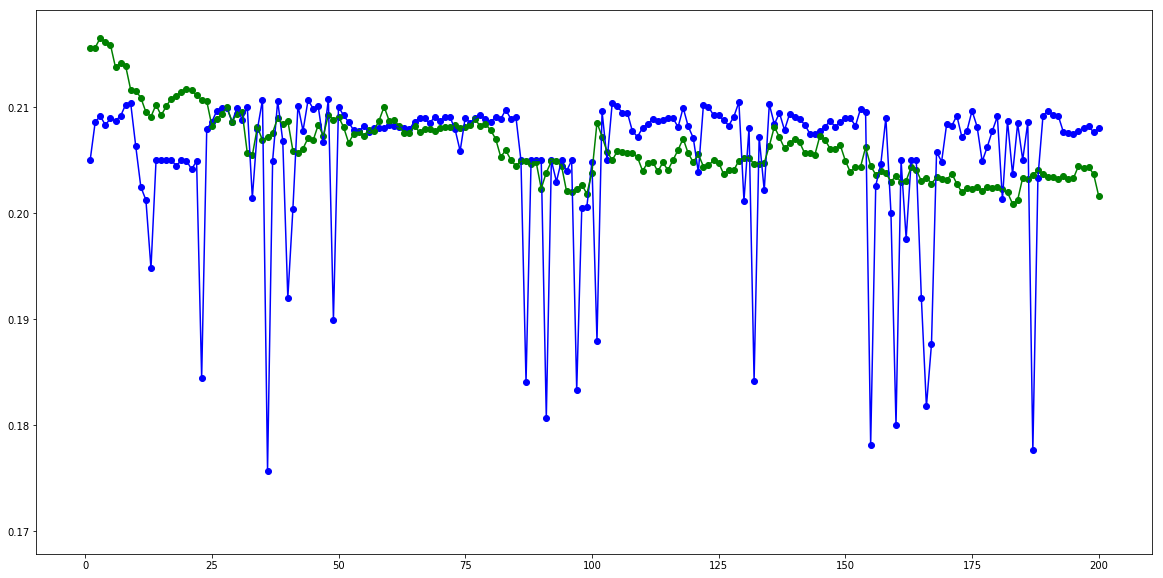

In [11]:
plt.figure(figsize=(20,10))
# visualizer.plot()
# for color in ['blue', 'red']:
# for color in ['red']:
for color in ['blue']:
    color_df = visualizer.date_pred_targ_dict.get(color, pd.DataFrame())
    plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
    plt.plot(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
    plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
    plt.plot(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
#     plt.scatter([color_df.iloc[0,0]], [color_df.iloc[0, -2]*10], color=color)
#     plt.plot([color_df.iloc[0,0]], [color_df.iloc[0, -2]*10], color=color)
#     plt.scatter([color_df.iloc[0,0]], [color_df.iloc[0, -1]*10], color='g')
#     plt.plot([color_df.iloc[0,0]], [color_df.iloc[0, -1]*10], color='g')
plt.show()

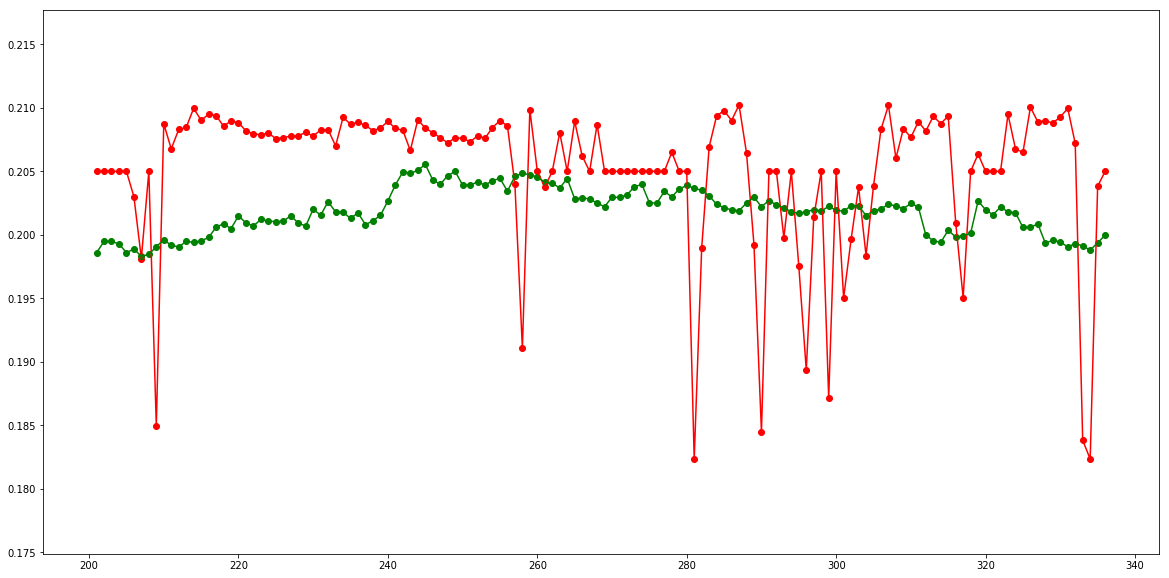

In [12]:
plt.figure(figsize=(20,10))

for color in ['red']:
    color_df = visualizer.date_pred_targ_dict.get(color, pd.DataFrame())
    plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
    plt.plot(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
    plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
    plt.plot(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
#     plt.scatter([color_df.iloc[0,0]], [color_df.iloc[0, -2]*10], color=color)
#     plt.plot([color_df.iloc[0,0]], [color_df.iloc[0, -2]*10], color=color)
#     plt.scatter([color_df.iloc[0,0]], [color_df.iloc[0, -1]*10], color='g')
#     plt.plot([color_df.iloc[0,0]], [color_df.iloc[0, -1]*10], color='g')
plt.show()